<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_1D_shift_amortized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 6.9 MB/s 


In [5]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd
import torch
from torch import tensor
from torch import nn

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


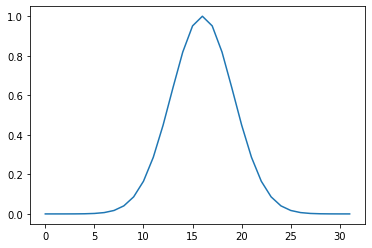

In [4]:
num_pix = 32
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal_gt = torch.sqrt(torch.tensor(10.))
clean_signal = torch.exp(-domain**2/(2*sigma_signal_gt**2))
pd.Series(clean_signal).plot()

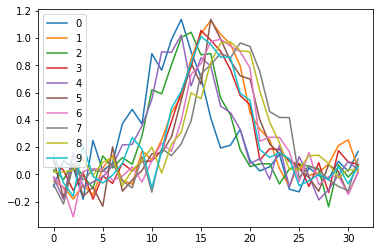

In [63]:
sigma_noise = 0.1
num_particles = 1000
data = torch.empty((num_particles,num_pix))
shifts_gt = torch.zeros(num_particles)
shift_loc_gt = 0
shift_scale_gt = 2
for i in range(num_particles):
  shift = dist.Normal(shift_loc_gt,shift_scale_gt).sample()
  shifts_gt[i] = shift
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal_gt**2))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()
pd.DataFrame(data[:10].numpy().T).plot()

In [64]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    input_size = num_pix
    hidden_layer_1_size = 4
    hidden_layer_2_size = 4
    output_size = 2
    self.layers = nn.Sequential(
      nn.Linear(input_size,hidden_layer_1_size),
      nn.Linear(hidden_layer_1_size, hidden_layer_2_size),
      nn.ReLU(),
      nn.Linear(hidden_layer_2_size, output_size)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

mlp = MLP()

In [65]:
def model(one_particle):
  shift = pyro.sample("shift", dist.Normal(0, 2))
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal_gt**2))
  with pyro.plate('data',num_pix):
    pyro.sample("particle", dist.Normal(clean_signal, sigma_noise).to_event(1), obs=one_particle)

def guide(one_particle): # the proposal distribution
  """
  mlp will be trained on many particles to predict params of distribution
  """
  pyro.module("mlp", mlp)
  loc, log_scale = mlp(one_particle)
  scale = torch.exp(log_scale)
  pyro.sample("shift", dist.Normal(loc, scale))

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide, 
                     optim=pyro.optim.Adam({"lr": 0.03}), 
                     loss=pyro.infer.Trace_ELBO())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


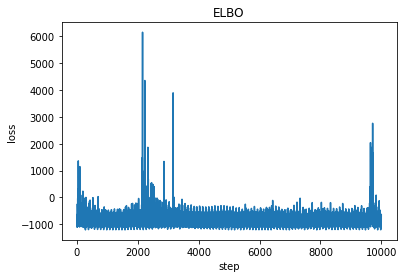

In [71]:
losses = []
num_steps = 10000
random_idx = torch.randperm(num_particles) 

for t in range(num_steps):
  if num_steps < 10 or (t % (num_steps//10)) == 0: print(t)
  one_particle = data[random_idx[t%100]]
  losses.append(svi.step(one_particle))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [72]:
amortized_loc_predictions = []
amortized_scale_predictions = []
for pair in data:
  amortized_loc, amortized_log_scale = mlp(pair)
  amortized_loc_predictions.append(amortized_loc.item())
  amortized_scale_predictions.append(torch.exp(amortized_log_scale).item())


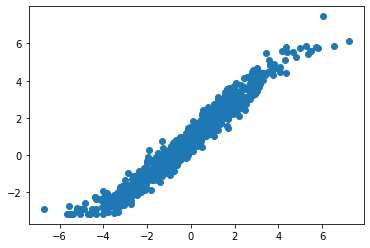

In [73]:
plt.scatter(y=amortized_loc_predictions,x=shifts_gt)